In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

import toolbox
import fcn
import yaml
import shutil
import sys

import chainer

%matplotlib inline
sns.set()

%load_ext autoreload
# Note: this reload all lib at each cell exec, just for convenience
%autoreload 2 

chainer.print_runtime_info()

In [3]:
# Plotting

import skimage.color
import skimage.segmentation
from matplotlib.lines import Line2D

def fill_semantic_seg(img, labels, n_class, masks,
                         captions=None, thickness=1, alpha=0.5):
    # Sort all by mask size
    masks, labels, captions = list(zip(*sorted(
        zip(masks, labels, captions), key=lambda x: np.sum(x[0]), reverse=True)))
    
    labels = np.asarray(labels).copy()
    captions = np.asarray(captions).copy()
    masks = np.asarray(masks).copy()
    nb_pixels = masks.shape[-2] * masks.shape[-1]
    
    img_viz = img.copy()
    # Turn to 3 channels gray
    img_viz = cv2.cvtColor(cv2.cvtColor(img_viz, cv2.COLOR_RGB2GRAY), cv2.COLOR_GRAY2RGB)
    cmap_inst = np.array(sns.color_palette(palette="colorblind"))
    
    legends = []
    for i_box, mask_inst in enumerate(masks):
        inst_class = labels[i_box]
        mask_inst = masks[i_box]

        color_inst = cmap_inst[i_box % len(cmap_inst)]
        legends.append((color_inst, "{:5.1%}:  {}".format(
            np.sum(mask_inst) / nb_pixels, captions[i_box])))
        color_inst = (color_inst * 255)

        img_viz[mask_inst] = (
            img_viz[mask_inst] * (1 - alpha) +
            color_inst * alpha
        )
        mask_boundary = skimage.segmentation.find_boundaries(
            mask_inst, connectivity=1)
        img_viz[mask_boundary] = [200, 200, 200]
        assert img_viz.dtype == np.uint8
    
    return img_viz, legends

def plot_semantic_seg(img, semaseg, labelmap, labels_sema, *, ax=None, fig=None):
    buff = []
    for i, label in enumerate(labels_sema):
        m = labelmap == label
        m = cv2.resize(m.astype(np.uint8), img.shape[1::-1], interpolation=cv2.INTER_NEAREST)
        buff.append(m > 0)
    buff = np.array(buff)

    captions = ["{}".format(semaseg._classes[label]) for label in labels_sema]

    out, legends = fill_semantic_seg(
        img=img,
        labels=labels_sema + 1,
#         n_class=len(semaseg._classes) + 1,
        n_class=182,
        captions=captions,
        masks=buff,
        alpha=0.5
    )

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))
    ax.imshow(out)
    ax.set_axis_off()

    _legend = [Line2D([0], [0], marker='o', color="white", label=lab,
                              markerfacecolor=color, markersize=12, alpha=0.5) for color, lab in legends]
    ax.legend(handles=_legend, loc=6, bbox_to_anchor=(1, 0.5), title="Classes sorted by area")
    ax.set_title("Semantic")
    return fig, ax

def plot_instance_seg(img, instaseg, bbox, mask, label, score, semaseg, *, ax=None, fig=None):
    if bbox is None:
        return
    captions = ['{:4.1%}: {}'.format(s, semaseg._classes[l]) for l, s in zip(label, score)]
#     captions = ['{:4.1%}'.format(s) for l, s in zip(label, score)]

    out = toolbox.utils.draw_instance_bboxes(
        img=img,
        bboxes=bbox,
#         labels=label + 1,
        labels=(label + 1) % 82,
#         n_class=len(instaseg._class_names) + 1,
        n_class=182,
        captions=captions,
        masks=mask,
    )
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))
    ax.imshow(out)
    ax.set_axis_off()
    ax.set_title("Instance")
    return fig, ax

In [4]:
%%time
from models import InstanceSeg, SemanticSeg, PanopticSeg

print("Preparing instance segmentation model...", end=" ")
instaseg = InstanceSeg(
    "./2018-12-03_23-24/20181203_232507/params.yaml",
    "./2018-12-03_23-24/20181203_232507/snapshot_model_45000.npz",
    gpu=0,
)
print("Done")

print("Preparing semantic segmentation model...", end=" ")
semaseg = SemanticSeg(
    "./toolbox/deeplab/config/cocostuff164k.yaml",
    "./cocostuff164k_iter100k.pth",
    gpu=0,
)
print("Done")

print("Preparing panotpic model...", end=" ")
panoseg = PanopticSeg(instaseg, semaseg, thresh=0.7, frac=0.2)
print("Done")

Preparing instance segmentation model... Done
Preparing semantic segmentation model... Done
Preparing panotpic model... Done
CPU times: user 4.05 s, sys: 649 ms, total: 4.7 s
Wall time: 4.7 s


In [5]:
# Load an external image
import skimage

img = skimage.io.imread("./external_test/barrage.jpg")
# img = skimage.io.imread("./external_test/basket_bw.jpg")
# img = skimage.io.imread("./external_test/bride_stars.jpg")
# img = skimage.io.imread("./external_test/fanac.jpg")
# img = skimage.io.imread("./external_test/light_painting.jpg")
# img = skimage.io.imread("./external_test/mountain.jpg")

In [6]:
%%time
# segment, RGB = panoseg.predict(img)
bbox, mask, label, score = panoseg._predict_instance(img)
labelmap, labels_sema = panoseg._predict_semantic(img)

CPU times: user 1.99 s, sys: 666 ms, total: 2.65 s
Wall time: 2.64 s


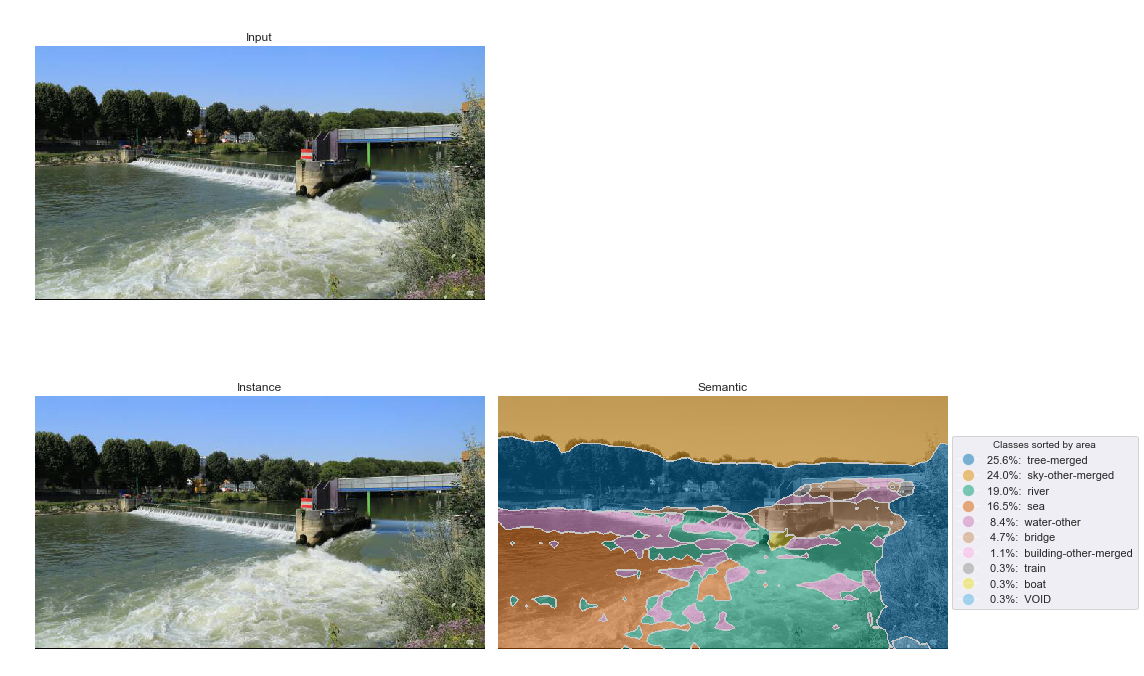

In [7]:
import random
import cv2

_ids = random.sample(range(1, 16711422), len(label) + len(labels_sema[labels_sema != -1]))
ids_instance = _ids[:len(label)]
ids_semantic = _ids[len(label):]

fig, ax = plt.subplots(figsize=(16, 10), nrows=2, ncols=2, sharex=True, sharey=True)
[a.set_axis_off() for a in ax.ravel()]
ax[0][0].imshow(img)
ax[0][0].set_title("Input")

plot_instance_seg(img, instaseg, bbox, mask, label, score, semaseg, ax=ax[1][0])
plot_semantic_seg(img, semaseg, labelmap, labels_sema, ax=ax[1][1])

fig.tight_layout()
plt.show()


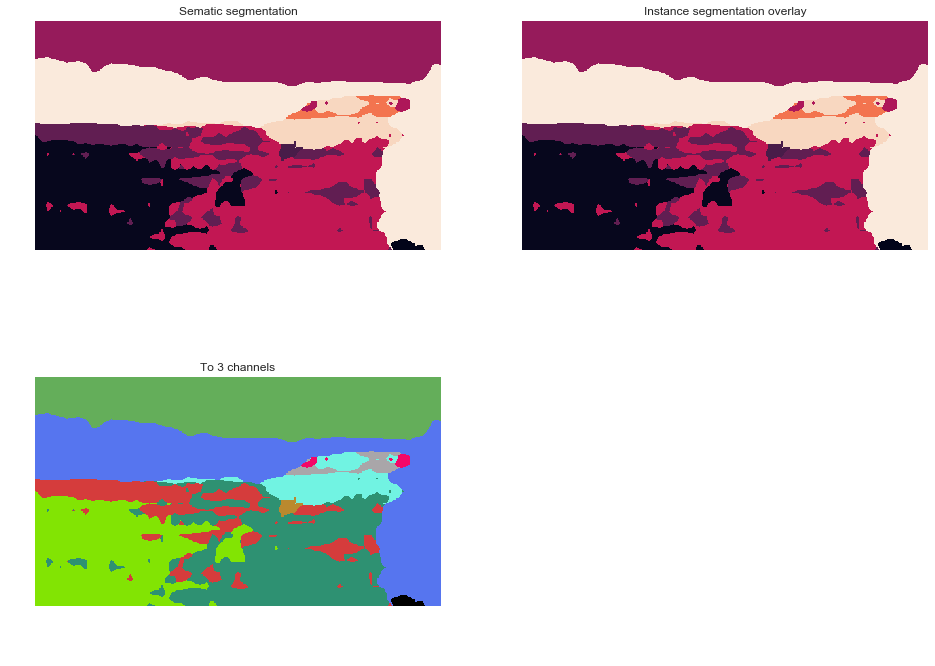

In [8]:
fig, ax = plt.subplots(figsize=(16, 12), nrows=2, ncols=2, sharex=True, sharey=True)
[a.set_axis_off() for a in ax.ravel()]

canvas = np.zeros(img.shape[:2])

# Semantic first
for idx, lab in enumerate(labels_sema[labels_sema != -1]):
    canvas[labelmap == lab] = ids_semantic[idx]

ax[0][0].imshow(canvas)
ax[0][0].set_title("Sematic segmentation")

# Instance next
for idx, m in enumerate(mask):
    canvas[m] = ids_instance[idx]

ax[0][1].imshow(canvas)
ax[0][1].set_title("Instance segmentation overlay")

RGB = np.zeros(img.shape, dtype=np.uint8)
for u in np.unique(canvas):
    r, g, b = panoseg.id_to_color(u)
    RGB[canvas == u, 0] = r
    RGB[canvas == u, 1] = g
    RGB[canvas == u, 2] = b
    
ax[1][0].imshow(RGB)
ax[1][0].set_title("To 3 channels")
plt.show()